In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn


In [2]:
n_epochs = 200
lr = 0.1
hidden_size_lstm = 32
hidden_layers_lstm = 2
test_size = 0.85
T = 100
PredictionSteps = 14

In [3]:
df = pd.read_csv("./../data/GOOGL.csv", header=0, index_col=0)

df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [4]:
X = df.iloc[:, :]
# X = np.reshape(np.array(df.iloc[:, 0]), (-1, 1))

Y = np.reshape(np.array(df.iloc[:, 0]), (-1, 1))

print(f"Inputs shape: {X.shape}")
print(f"Outputs shape: {Y.shape}")


Inputs shape: (4495, 6)
Outputs shape: (4495, 1)


In [5]:
from sklearn.preprocessing import StandardScaler

N_train = np.int64(X.shape[0] * test_size)
N_tot = X.shape[0]

if (N_tot-N_train < PredictionSteps+T): N_train=N_tot-(PredictionSteps+T+1)
print(f'Train size: {N_train}, Test size: {N_tot-N_train-PredictionSteps-T}')

scaler = StandardScaler()
# we scale by looking only on the training data, thus test data is not considered
scaler.fit(X[:N_train+T-1])
# but we still apply scaling on all the data since we need to be able to make predictions
X = scaler.transform(X)

scaler = StandardScaler()
# we scale by looking only on the training data, thus test data is not considered
scaler.fit(Y[:N_train+T-1])
# but we still apply scaling on all the data since we need to be able to make predictions
Y = scaler.transform(Y)


Train size: 3820, Test size: 561


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")


Device: cuda


In [7]:
inputs = np.zeros((N_tot - T - PredictionSteps, T, X.shape[1]))
targets = np.zeros((N_tot - T - PredictionSteps, PredictionSteps))

for t in range(N_tot - T - PredictionSteps):
    inputs[t] = X[t : t + T]
    targets[t] = np.reshape(Y[t + T : t + T + PredictionSteps], -1)

In [8]:
train_inputs = torch.from_numpy(inputs[:N_train].astype(np.float32)).to(device)
train_targets = torch.from_numpy(targets[:N_train].astype(np.float32)).to(device)
test_inputs = torch.from_numpy(inputs[N_train:].astype(np.float32)).to(device)
test_targets = torch.from_numpy(targets[N_train:].astype(np.float32)).to(device)

print(
    f"Train shapes: {train_inputs.shape} for Inputs and {train_targets.shape} for Targets"
)
print(
    f"Test shapes: {test_inputs.shape} for Inputs and {test_targets.shape} for Targets"
)


Train shapes: torch.Size([3820, 100, 6]) for Inputs and torch.Size([3820, 14]) for Targets
Test shapes: torch.Size([561, 100, 6]) for Inputs and torch.Size([561, 14]) for Targets


In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, outputs_size, device="cpu"):
        super(RNN, self).__init__()

        self.device = device

        self.D = input_size
        self.M = hidden_size
        self.L = num_layers
        self.K = outputs_size

        self.rnn_layer = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        self.fc = nn.Linear(self.M, self.K)

    def forward(self, inputs):

        h0 = torch.zeros((self.L, inputs.size(0), self.M)).to(self.device)
        c0 = torch.zeros((self.L, inputs.size(0), self.M)).to(self.device)

        outputs, _ = self.rnn_layer(inputs, (h0, c0))
        outputs = self.fc(outputs[:, -1, :])

        return outputs


In [10]:
model = RNN(
    input_size=inputs.shape[2],
    outputs_size=targets.shape[1],
    hidden_size=hidden_size_lstm,
    num_layers=hidden_layers_lstm,
    device=device,
)
model.to(device)


RNN(
  (rnn_layer): LSTM(6, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=14, bias=True)
)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()


In [12]:
def train(
    model,
    optimizer,
    criterion,
    train_inputs,
    train_targets,
    test_inputs,
    test_targets,
    n_epochs=200,
):
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)

    for it in range(n_epochs):

        optimizer.zero_grad()
        outputs = model(train_inputs)
        loss = criterion(outputs, train_targets)
        loss.backward()
        optimizer.step()

        train_losses[it] = loss.item()
        test_losses[it] = criterion(model(test_inputs), test_targets).item()

        print(
            f"Iteration: {it+1:2.0f}/{n_epochs} \t Train Loss: {train_losses[it]:.4f} \t Test Loss: {test_losses[it]:.4f}"
        )

    return train_losses, test_losses


In [13]:
train_losses, test_losses = train(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_inputs=train_inputs,
    train_targets=train_targets,
    test_inputs=test_inputs,
    test_targets=test_targets,
    n_epochs=n_epochs,
)

Iteration:  1/200 	 Train Loss: 1.0047 	 Test Loss: 17.6264
Iteration:  2/200 	 Train Loss: 0.3635 	 Test Loss: 8.3469
Iteration:  3/200 	 Train Loss: 2.8654 	 Test Loss: 20.8083
Iteration:  4/200 	 Train Loss: 0.8918 	 Test Loss: 21.8847
Iteration:  5/200 	 Train Loss: 0.5484 	 Test Loss: 17.2147
Iteration:  6/200 	 Train Loss: 0.5484 	 Test Loss: 15.4792
Iteration:  7/200 	 Train Loss: 0.2045 	 Test Loss: 14.1411
Iteration:  8/200 	 Train Loss: 0.1852 	 Test Loss: 13.4686
Iteration:  9/200 	 Train Loss: 0.1713 	 Test Loss: 13.4519
Iteration: 10/200 	 Train Loss: 0.1238 	 Test Loss: 12.3159
Iteration: 11/200 	 Train Loss: 0.1360 	 Test Loss: 15.8220
Iteration: 12/200 	 Train Loss: 0.0809 	 Test Loss: 14.8310
Iteration: 13/200 	 Train Loss: 0.0773 	 Test Loss: 10.1735
Iteration: 14/200 	 Train Loss: 0.0816 	 Test Loss: 9.3177
Iteration: 15/200 	 Train Loss: 0.0744 	 Test Loss: 9.2123
Iteration: 16/200 	 Train Loss: 0.0440 	 Test Loss: 9.2643
Iteration: 17/200 	 Train Loss: 0.0594 	 Tes

Text(0.5, 1.0, 'Loss per Iteration')

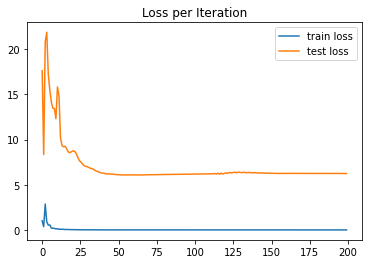

In [14]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.title("Loss per Iteration")


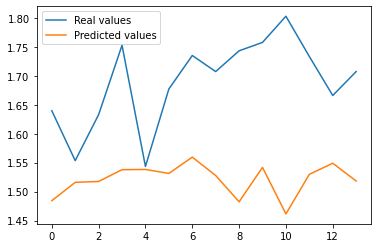

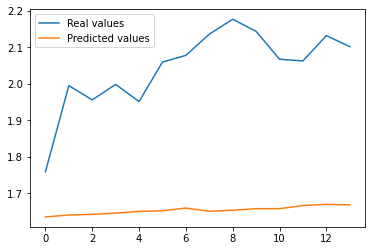

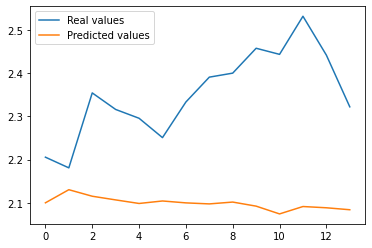

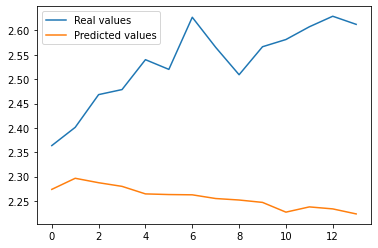

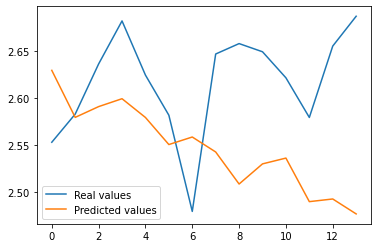

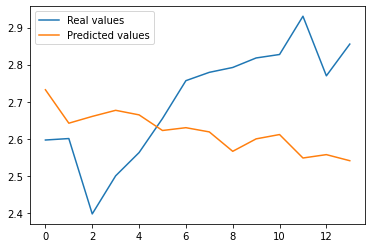

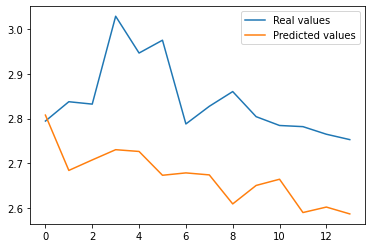

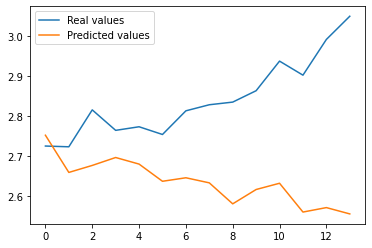

In [15]:
for i in range(0,100, 14):
    plt.figure(i)
    plt.plot(test_targets[i].cpu(), label='Real values')
    plt.plot(model(test_inputs[i].view(1, T, -1)).view(-1).cpu().detach(), label='Predicted values')
    plt.legend()

In [16]:
def plot_horizon(): 
    horizon_predictions = np.array([])
    horizon_inputs = test_inputs[0]
    
    while horizon_predictions.shape[0] < test_targets.shape[0]:
        prediction = model(horizon_inputs.view(1, T, 1)).view(-1)
        
        horizon_predictions = np.concatenate((horizon_predictions, prediction.cpu().detach()), axis=0)
        
        horizon_inputs = torch.concat((horizon_inputs[-(T-PredictionSteps):].view(-1), prediction[-T:]))
    
    plt.plot(test_targets.cpu()[:, 0])  
    plt.plot(horizon_predictions)

plot_horizon() if X.shape == Y.shape else print('Unable to plot Horizon')

Unable to plot Horizon
